# Geometric Deep Learning
Graph Node Classification using PyTorch Geometric on the Amazon Computers dataset.


## Introduction and requirements

PyTorch Geometric is a geometric deep learning (GDN) extension library for PyTorch. In general GDN is used to generalize deep learning for non-Ecludian data, such as graphs.

In this notebook we will demonstrate the use of this framework to classify Amazon products to their categories. More specifically, we will use the dataset presented in "" where nodes are products and edges are 

In [1]:
!pip install --upgrade torch-scatter
!pip install --upgrade torch-sparse
!pip install --upgrade torch-cluster
!pip install --upgrade torch-spline-conv 
!pip install torch-geometric

  Using cached https://files.pythonhosted.org/packages/98/a9/47cd92673b6ba251240d587815c763baac2099b07bb76fecdb3b7ae5cece/torch_scatter-2.0.4.tar.gz
  Created wheel for torch-scatter: filename=torch_scatter-2.0.4-cp36-cp36m-linux_x86_64.whl size=12144044 sha256=6e8abef8aad383a32ffe53fde00c8353f3bee0dce2183a0decdcaf6364a9a18f
  Stored in directory: /root/.cache/pip/wheels/fb/28/28/458ddcee4849d5f8a14dd1be1e957d2e8b2955e8c96b07a12d
Successfully built torch-scatter
  Using cached https://files.pythonhosted.org/packages/92/d4/7261b5ee3ff529ac3652fda2ad9757c0fb3cde514014a9c26fe71bad38e9/torch_sparse-0.6.4.tar.gz
  Created wheel for torch-sparse: filename=torch_sparse-0.6.4-cp36-cp36m-linux_x86_64.whl size=23636504 sha256=250417c7bb8e1bb7597aa7587aebb9ee480e4df12009e495c5234affa3ff13c2
  Stored in directory: /root/.cache/pip/wheels/70/d3/b3/374d9a7ebf5b1117d651bb20051e387009baa2e37c9339a525
Successfully built torch-sparse
  Created wheel for torch-cluster: filename=torch_cluster-1.5.4-cp36-c

![alt text](https://raw.githubusercontent.com/rusty1s/pytorch_geometric/master/docs/source/_static/img/pyg_logo_text.svg?sanitize=true)

First of all, import the necessary libraries

In [0]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Amazon
import torch_geometric.transforms as T
from torch_geometric.nn import SplineConv

## Load the dataset

We load the Amazon Computers dataset which is comprised of networks, where nodes represent goods and edges represent that two goods are frequently bought together. 



In [3]:
dataset = 'Computers'
root='/tmp/Amazon'
dataset = Amazon(root, dataset, transform=T.TargetIndegree())
data = dataset[0]

Processing...
Done!


## Explore the data

A graph is used to model pairwise relations (edges) between objects (nodes). A single graph in PyTorch Geometric is described by an instance of torch_geometric.data.Data, which holds the following attributes:

*   **data.x:**  Node feature matrix with shape [num_nodes, num_node_features]


*   **data.edge_index:**  Graph connectivity in COO format with shape [2, num_edges] and type torch.long

*  **data.edge_attr:**  Edge feature matrix with shape [num_edges, num_edge_features]

*   **data.y:** The label of each instance of the dataset.






In [4]:
print(data,end="\n\n")

print("Dataset classes = " + str(dataset.num_classes))
print("Labels in [" + str(int(min(data.y))) + ", " + str(int(max(data.y))) + "]")
print("data.y = ",end="")
print(data.y,end="\n\n")

print("Number of Nodes = " + str(data.num_nodes))
print("Features per Node = " + str(dataset.num_node_features))
print("data.x = ", end="")
print(data.x,end="\n\n")

print("Number of edges = " + str(data.num_edges))
print("Features per edge = " + str(dataset.num_edge_features))
print("data.edge_index = ", end="")
print(data.edge_index)
print("data.edge_attr = ",end="")
print(data.edge_attr)

Data(edge_attr=[491722, 1], edge_index=[2, 491722], x=[13752, 767], y=[13752])

Dataset classes = 10
Labels in [0, 9]
data.y = tensor([4, 4, 8,  ..., 8, 4, 0])

Number of Nodes = 13752
Features per Node = 767
data.x = tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 1., 1., 0.]])

Number of edges = 491722
Features per edge = 1
data.edge_index = tensor([[    0,     0,     0,  ..., 13751, 13751, 13751],
        [  507,  6551,  8210,  ..., 12751, 13019, 13121]])
data.edge_attr = tensor([[0.0471],
        [0.1029],
        [0.8382],
        ...,
        [0.0431],
        [0.0411],
        [0.0087]])


Given this dataset, a question that might come to mind is whether the frequency of two products being bought together is related with their category.
In the follow in Histogram we will figure out whether two items that are more frequetly bought together, are also more likely to belong in the same class.

In [0]:
import math
import numpy as np

productsCount = np.zeros(10)
sameClassCount = np.zeros(10)
# Iterate through the edges
for edge_index in range(data.num_edges):
  freqIndex = math.floor(data.edge_attr[edge_index]*10)
  if (freqIndex == 10):
    freqIndex = 9

  productsCount[freqIndex] +=1
  # If they belong in the same class 
  if (data.y[data.edge_index[0][edge_index]] == data.y[data.edge_index[1][edge_index]]):
    sameClassCount[freqIndex] +=1

In [6]:
# Divide same class products with products count of each frequency index
np.seterr(divide='ignore', invalid='ignore')
y = np.nan_to_num(sameClassCount/productsCount)
print(y)
print()
print(productsCount)

[0.79089507 0.7520564  0.73329105 0.70463629 0.85275591 0.82747604
 0.13135135 0.         0.52368579 0.11463904]

[432491.  28934.  12613.   5004.   1270.   1565.   1850.      0.   5003.
   2992.]


We end up with the following graph, where the x axis is the frequency of two products being bought together (divided into 10 bars) and the y axis is the percentage of items that belong in the same category.


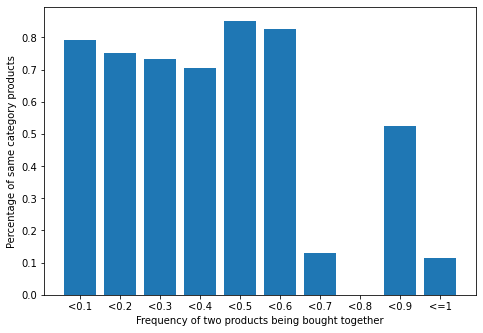

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Frequency of two products being bought together')
ax.set_ylabel('Percentage of same category products')
langs = ['<0.1', '<0.2', '<0.3', '<0.4', '<0.5', '<0.6', '<0.7', '<0.8', '<0.9', '<=1']
ax.bar(langs,y)
plt.show()

As we see, the items that are frequently bought together, are less likely to belong in the same category. Therefore the edges attribute is not sufficient in order to classify the products, and as a result we certainly need to take advantage of the nodes features.

## Split the training, test and validation set

In [0]:
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:data.num_nodes - 1000] = 1

data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[data.num_nodes - 500:] = 1

data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask[data.num_nodes - 1000:data.num_nodes - 500] = 1

## Building the Neural Network

The network will consist of two SplineConv layers for convolution. 

Additionally, we use the exponential ReLU activation function and dropout for regularization.

In [0]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SplineConv(dataset.num_features, 16, dim=1, kernel_size=2)
        self.conv2 = SplineConv(16, dataset.num_classes, dim=1, kernel_size=2)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = self.conv2(x, edge_index, edge_attr)
        return F.log_softmax(x, dim=1)

Create an instance of our network and use adam optimizer.

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-3)

def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()

def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs
  
def validate():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('val_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

## Training and evaluation

In [14]:
for epoch in range(1, 301):
    train()
    log = 'Epoch: {:03d}, Train: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, *test()))

Epoch: 001, Train: 0.3763, Test: 0.3500
Epoch: 002, Train: 0.3903, Test: 0.3520
Epoch: 003, Train: 0.2602, Test: 0.2600
Epoch: 004, Train: 0.4184, Test: 0.4040
Epoch: 005, Train: 0.4330, Test: 0.3980
Epoch: 006, Train: 0.3790, Test: 0.3540
Epoch: 007, Train: 0.3685, Test: 0.3440
Epoch: 008, Train: 0.3749, Test: 0.3420
Epoch: 009, Train: 0.4079, Test: 0.3860
Epoch: 010, Train: 0.5103, Test: 0.4720
Epoch: 011, Train: 0.5710, Test: 0.5240
Epoch: 012, Train: 0.6008, Test: 0.5660
Epoch: 013, Train: 0.6527, Test: 0.6180
Epoch: 014, Train: 0.6444, Test: 0.6400
Epoch: 015, Train: 0.6115, Test: 0.5840
Epoch: 016, Train: 0.5838, Test: 0.5540
Epoch: 017, Train: 0.5804, Test: 0.5500
Epoch: 018, Train: 0.5947, Test: 0.5540
Epoch: 019, Train: 0.6304, Test: 0.6200
Epoch: 020, Train: 0.6830, Test: 0.6660
Epoch: 021, Train: 0.7003, Test: 0.6800
Epoch: 022, Train: 0.7092, Test: 0.6800
Epoch: 023, Train: 0.7123, Test: 0.6940
Epoch: 024, Train: 0.7021, Test: 0.6920
Epoch: 025, Train: 0.6903, Test: 0.6700


Now lets run our network on the validation data, in order to calculate its accuracy on new data.

In [17]:
print("Accuracy: {:.4f}".format(validate()[0]))

Accuracy: 0.9160
